In [1]:
import numpy as np
%matplotlib inline

import pandas as pd

%pylab inline
#import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table
from astropy.io import fits
from importlib import reload
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm
from decimal import *
import sys
from scipy.ndimage import zoom 
from mpl_toolkits.axes_grid.inset_locator import inset_axes

import input
reload (input)
from input import *

#print('reading chain %0.2f 0.2f ' % ((xmass[kk]-obs_bin/2.),(xmass[kk]+obs_bin/2))         

print('reading chains %s' % chains_file)

#find number of steps combining all chains
N_steps=0
for ii in range(0,N_chains):
    char_ii="%d" % ii
    df=pd.read_csv(chains_dir+chains_file+'_'+char_ii+'.txt',sep=' ',
                  names=['0','1','2','3','4','5','6','7','8','9',
                         '10','11','12','13','14','15','16','17','18'])  
 
    #print('chain %d, steps=%d' % (ii, len(df.index)))
    N_steps+=len(df.index)     
print("Total Steps:", N_steps)
N_steps=N_steps-(Burn_In*N_chains)
print("Excluding %d BurnIn steps:" % Burn_In, N_steps)
print("")

#create data frame with total size
df=pd.DataFrame(np.zeros((N_steps,N_par+2),dtype=np.float64),
                columns=['0','1','2','3','4','5','6','7','8','9',
                         '10','11','12','13','14','15','16','17','18'])


#read individual chains into big data frame
offset=0

for ii in range(0,N_chains):
    char_ii="%d" % ii  
    aux_df=pd.read_csv(chains_dir+chains_file+'_'+char_ii+'.txt',sep=' ',header=None,
                      names=['0','1','2','3','4','5','6','7','8','9',
                             '10','11','12','13','14','15','16','17','18'])   
    #iloc - position based (to ignore the indexes), loc - label based
    short_aux_df=aux_df[Burn_In:len(aux_df.index)]
    #the indexes in df and aux_df must be exactly the same, otherwise all nans
    short_aux_df = short_aux_df.set_index(np.arange(int(offset),int(offset+len(aux_df.index)-Burn_In)))
    df.iloc[offset:offset+len(aux_df.index)-Burn_In] = short_aux_df   
    offset+=(len(aux_df.index)-Burn_In)  

  
''';coldgas crit parameter has new normalization
;;data(j,3,*)=Alog10(10^data(j,3,*)*2.)
;radio mode feedback parameter has new normalization
;1.25 meaningless, just to get the right value
;;data(j,6,*)=Alog10(10^data(j,6,*)*0.673*0.673*1.25)'''
     
#print stats:
print('Max Log10(Like)=%0.8g' % min(df.iloc[:,1]))
#print('Max Log10(Like)=%0.8g' % min(df.loc[:,'1']))
#print('Max Log10(Like)=%0.8g' % min(df.values[:,'1']))
#print('Max Log10(Like)=%0.8g' % min(df.values[:,1]))

#select all best fit steps
best_fit_steps=df[df.iloc[:,1] == min(df.iloc[:,1])]
'''for ii, item in enumerate(best_fit_steps.iloc[0]):   # default is zero
    if(ii>1):
        print('Par[%d]=%0.2g ' % (ii-2, 10**item), end="")'''
for ii, item in enumerate(best_fit_steps.iloc[0,:]):   # default is zero
    if(ii>1):
        print('%0.2g ' % (10**item), end="")
        
print("")
print("")
bestfit=best_fit_steps.iloc[0,:]
#print(min(df.iloc[:,1])*1.2)
#df=df[df.iloc[:,1] < min(df.iloc[:,1])*2.0]
#max_log_like=35
df=df[df.iloc[:,1] < max_log_like]

print('max_log_like',max_log_like)
print("Nsteps after limiting like:",len(df))


#sel_df=df[df.iloc[:,8] < np.log10(0.2)]
#print(10**sel_df.iloc[0,:])

#sel_df=df[df.iloc[:,8] > np.log10(7.)]
#print(10**sel_df.iloc[0,:])



print("")
print("")
print("Reading done")

#print(best_fit_steps.iloc[0].to_frame().T)

Populating the interactive namespace from numpy and matplotlib


/export/data1/Workspace/GitHub_Python_plots/env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


reading chains senna_g2
Total Steps: 99730
Excluding 0 BurnIn steps: 99730

Max Log10(Like)=138.03552
2.3e-09 0.19 1.9 0.0071 0.042 2.8e+03 4.6 96 2.9 4.7 31 3.3 2.6e+10 0.12 0.78 0.25 1.1e+04 

max_log_like 400.0
Nsteps after limiting like: 61021


Reading done


## Marginalized Statistics

In [2]:
def ConfidVal(ix, limfrac, upper, nrows):    
    l=0
    t=nrows
 
    try_b = min(df.iloc[:,ix])
    try_t = max(df.iloc[:,ix])
   
    samps = sum(df.iloc[l:t,0])
         
    lasttry = -1    
   

    if (upper==1):

        while True:        
            aux=df.iloc[:,ix]       
            sel=aux > (try_b + try_t)/2
            var_try=len(aux[sel])
            if (var_try > samps*limfrac):
                try_b = (try_b+try_t)/2 
            else:
                try_t = (try_b+try_t)/2
        
            if (var_try==lasttry): break
            lasttry = var_try      
    else:   
        while True:
            aux=df.iloc[:,ix]       
            sel=aux < (try_b + try_t)/2
            var_try=len(aux[sel])
            if (var_try>samps*limfrac):
                try_t = (try_b+try_t)/2 
            else:
                try_b = (try_b+try_t)/2
    
            if (var_try==lasttry): break
            lasttry = var_try
     
    
    
    return (try_t)

for ii in range (0, N_par):   
    
    #compute regions
    upper=ConfidVal(ii+2,(1-0.955)/2.,1, N_steps)   
    lower=ConfidVal(ii+2,(1-0.955)/2.,0, N_steps) 
       
    #best fit
    if(fix_max_like == 0):
        aux=df[df.iloc[:,1] == min(df.iloc[:,1])].iloc[0]   
    else:
        aux=df[df.iloc[:,1] == max_log_like].iloc[0]        
        
    if(ii==0):
        print(' par','  best fit','     lower','      upper')    
        
    #print, ii, 10^aux(0,0,0), 10^lower, 10^upper, aux(0,0,0), lower, upper     
    print("  %d" % ii, end="" )
    
    if(ii<10):
        for jj in range (0,12-len("%0.2g" % 10**aux[ii+2])):
            print(" ", end="");
    else:
        for jj in range (0,11-len("%0.2g" % 10**aux[ii+2])):
            print(" ", end="");            
    print("%0.2g" % (10**aux[ii+2]), end="" )
    
    for jj in range (0,11-len("%0.2g" % 10**lower)):
            print(" ", end="");            
    print("%0.2g" % (10**lower), end="")
    
    for jj in range (0,11-len("%0.2g" % 10**upper)):
            print(" ", end="");            
    print("%0.2g" % (10**upper))
    
    #print("  %d    %0.2g    %0.2g    %0.2g" % (ii, 10**aux[ii+2], 10**lower, 10**upper) )
    
    #print("  %d    %0.2g    %0.2g    %0.2g" % (ii, 10**aux[ii+2], 10**lower, 10**upper) )
        
        
print("")
    
#select bestfit inside MCMC 2-sigma regions

upper=np.zeros(N_par,dtype=np.float64)
lower=np.zeros(N_par,dtype=np.float64)

for ii in range (0, N_par):   
    
    #compute regions
    upper[ii]=ConfidVal(ii+2,(1-0.955)/2.,1, N_steps)   
    lower[ii]=ConfidVal(ii+2,(1-0.955)/2.,0, N_steps) 
    
    if(ii==0):
        sel=(df.iloc[:,ii+2]>lower[ii]) & (df.iloc[:,ii+2]<upper[ii])
        df_inside_2sigma=df[sel]
    else:
        sel=(df_inside_2sigma.iloc[:,ii+2]>lower[ii]) & (df_inside_2sigma.iloc[:,ii+2]<upper[ii])
        df_inside_2sigma=df_inside_2sigma[sel]
    
    
#select all best fit steps
best_fit_inside_2sigma=df_inside_2sigma[df.iloc[:,1] == min(df_inside_2sigma.iloc[:,1])]
for ii, item in enumerate(best_fit_inside_2sigma.iloc[0,:]):   # default is zero
    if(ii>1):
        print('%0.2g ' % (10**item), end="")
print("")
best_fit_inside_2sigma=best_fit_inside_2sigma.iloc[0,:]



 par   best fit      lower       upper
  0     2.3e-09    4.6e-10    7.1e-09
  1        0.19       0.11       0.62
  2         1.9       0.33          2
  3      0.0071     0.0019     0.0093
  4       0.042      0.019      0.096
  5     2.8e+03    8.7e+02    2.9e+03
  6         4.6        1.6        9.3
  7          96         76    2.7e+02
  8         2.9        1.5        4.5
  9         4.7          2        9.8
  10         31         23    2.8e+02
  11        3.3       0.81        4.7
  12    2.6e+10      1e+10    5.3e+10
  13       0.12      0.069        0.6
  14       0.78       0.23       0.94
  15       0.25       0.11       0.48
  16    1.1e+04      1e+03    1.1e+04

2.3e-09 0.19 1.9 0.0071 0.042 2.8e+03 4.6 96 2.9 4.7 31 3.3 2.6e+10 0.12 0.78 0.25 1.1e+04 


/export/data1/Workspace/GitHub_Python_plots/env/lib/python3.5/site-packages/ipykernel_launcher.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## 1D Plots

In [3]:
def smooth(array, N):

    for jj in range(0, N):
        for ii in range (1, len(array)-2):
            array[ii]=(array[ii-1]+array[ii]+array[ii+1])/3.
        
    return(array)

import input
reload (input)
from input import *

plots_in_log=1

plt.rcParams.update({'font.size': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 1.5, 
                     'ytick.major.size': 6, 'ytick.major.width': 1.5, 
                     'xtick.minor.size': 3, 'xtick.minor.width': 1.,                   
                     'ytick.minor.size': 3, 'ytick.minor.width': 1.})  


with PdfPages('./fig/plots.pdf') as pdf:  
                
    for ii in range (0, N_par): 
    #for ii in range (1, 2):    
        if((ii==0) | (ii==7) | (ii==14)):
            fig = plt.figure(figsize=(22,4))
            grid = gridspec.GridSpec(1, 7)            
            i_grid=0
              
        subplot=plt.subplot(grid[i_grid])
        i_grid+=1
        if(plots_in_log==1):          
            interval=abs(max(df.iloc[:,ii+2])-min(df.iloc[:,ii+2]))
            mean=(min(df.iloc[:,ii+2])+max(df.iloc[:,ii+2]))/2.           
            xlim=[mean-interval/2.,mean+interval/2.]         
            xlim=[mean-interval,mean+interval]         
        else:
            xlim=[10**min(df.iloc[:,ii+2]),10**max(df.iloc[:,ii+2])]                   
            median=(xlim[1]+xlim[0])/2.
            #interval is 0.2 in log space
            xlim=[median-median*2./3,median+median*0.5]  
        
        
        ylim=[0.0, 1.0]         
        subplot.set_ylim(ylim), subplot.set_xlim(xlim)
           
        
        #format axis
        majorFormatter = FormatStrFormatter('%d')
        subplot.xaxis.set_major_locator(MultipleLocator(1))    
        subplot.xaxis.set_minor_locator(MultipleLocator(0.5)) 
                          
        subplot.set_xlabel(Par_Names[ii+2], fontsize=14) 
        if((ii==0) | (ii==7) | (ii==14)):
            subplot.set_ylabel('fraction', fontsize=14)    
            
        if((ii!=0) and (ii!=7) and (ii!=14)):
            plt.tick_params(axis='y', which='both', left='on', labelleft='off')
            
        #bin=(Alog10(xmax)-Alog10(xmin))/float(Nbins)
        #hist=histogram(Alog10(data[j,i+2,*]),locations=c,min=alog10(xmin)-bin*2.,max=alog10(xmax)+bin*2.,binsize=bin)
        #c=10^(c+bin/2.)                       
        #      oplot,c,hist/(total(hist))/max(hist/(total(hist))), color=color[j], thick=6 
                
        #Histograms    
        Nbins=20   
        if(plots_in_log==1):
            log_xlim=xlim
        else:
            log_xlim=np.log10(xlim)
        bin=(log_xlim[1]-log_xlim[0])/float(Nbins)
        bin_arr=np.arange(log_xlim[0],log_xlim[1]+bin,bin)
        hist=np.histogram(df.iloc[:,ii+2], bins=bin_arr, range=(log_xlim[0],log_xlim[1]))      
        x_axis=hist[1][0:len(hist[1][:])-1]+bin/2.           
        #y_axis=(hist[0]/sum(hist[0]))        
        y_axis=smooth(hist[0], 2)
        y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
        if(plots_in_log==1):
            subplot.plot(x_axis,y_axis, color='blue', linewidth=2, linestyle='-') 
        else:
            subplot.plot(10**x_axis,y_axis, color='blue', linewidth=2, linestyle='-')
        
        df_output=pd.DataFrame({'x':10**x_axis, 'y':y_axis})      
        char_ii="%d" % ii
        df_output.to_csv(chains_dir+chains_file+'_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
            
            
        #plot 2-sigma regions       
        sel=(x_axis>lower[ii]) & (x_axis<upper[ii])
        if(plots_in_log==1):
            subplot.fill_between(x_axis[sel],x_axis[sel]/x_axis[sel]-1.,y_axis[sel],facecolor='skyblue', 
                                 interpolate=True, alpha=0.4, edgecolor='skyblue')  
        else:
            subplot.fill_between(10**x_axis[sel],x_axis[sel]/x_axis[sel]-1.,y_axis[sel],facecolor='skyblue', 
                                 interpolate=True, alpha=0.4, edgecolor='skyblue')

        #Maximum likelihood
        max_like=df[df.iloc[:,1] == min(df.iloc[:,1])].iloc[0]     
        y_axis=np.arange(0,1,0.01)
        x_axis=y_axis/y_axis-1.+max_like[ii+2]
        if(plots_in_log==1):
            subplot.plot(x_axis,y_axis, color='royalblue', linewidth=3, linestyle='-')
        else:
            subplot.plot(10**x_axis,y_axis, color='royalblue', linewidth=3, linestyle='-')
        
        #best_fit_inside_2sigma
        y_axis=np.arange(0,1,0.01)
        x_axis=y_axis/y_axis-1.+best_fit_inside_2sigma[ii+2]
        if(plots_in_log==1):
            subplot.plot(x_axis,y_axis, color='royalblue', linewidth=3, linestyle='--')
        else:
            subplot.plot(10**x_axis,y_axis, color='royalblue', linewidth=3, linestyle='--')
            
        #plot other chains
        df_previous1=pd.read_csv(chains_dir+'senna_g1_0_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
        if(plots_in_log==1):
            subplot.plot(np.log10(df_previous1['x'][:]),df_previous1['y'], color='red', linewidth=2, linestyle='-') 
        else:
            subplot.plot(df_previous1['x'][:],df_previous1['y'], color='red', linewidth=2, linestyle='-')
            
        df_previous2=pd.read_csv(chains_dir+'senna_g2_0_1D_histogram_par_'+char_ii+'.txt',sep=' ')   
        if(plots_in_log==1):
            subplot.plot(np.log10(df_previous2['x'][:]),df_previous2['y'], color='green', linewidth=2, linestyle='-') 
        else:
            subplot.plot(df_previous2['x'][:],df_previous2['y'], color='green', linewidth=2, linestyle='-') 
    
        
        if((ii==6) | (ii==13) | (ii==N_par-1)): 
            plt.tight_layout() 
            grid.update(wspace=0.05, hspace=0.0)
            pdf.savefig()
            plt.close()

print("plots done")

/export/data1/Workspace/GitHub_Python_plots/env/lib/python3.5/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide
/export/data1/Workspace/GitHub_Python_plots/env/lib/python3.5/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


plots done


# Parameter scalings

In [12]:
plt.rcParams.update({'xtick.direction': 'in', 'ytick.direction': 'in'})

SN_Par_Pos=[7,8,9,10,11,12,13]


bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72,0.62,100.,0.80,3.0e+10,0.036,2.5,1.3e+04]))


#bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72, 0.62,1.0,0.80, 3.0e+10,0.036,2.5,1.3e+04]))

#bestfit=np.log10(bestfit)
print(bestfit.iloc[SN_Par_Pos])


G=4.3*10**(-9) #Mpc Msun^-1 (km/s)^2
H_z=array([100.0, 170.41, 284.11, 425.86]) #km/s/Mpc
Time_h=array([13.812, 5.850, 3.274, 2.142])
Time_h=Time_h*1.e9
V_max=10**np.arange(1.,5.,0.001)
#V_max=10**np.arange(1.,5.,0.1)


V_SN=630.

epsilon_bestfit=bestfit.iloc[SN_Par_Pos[0]]
V_disk_bestfit=bestfit.iloc[SN_Par_Pos[1]]
beta_1_bestfit=bestfit.iloc[SN_Par_Pos[2]]
eta_bestfit=bestfit.iloc[SN_Par_Pos[3]]
V_halo_bestfit=bestfit.iloc[SN_Par_Pos[4]]
beta_2_bestfit=bestfit.iloc[SN_Par_Pos[5]]
gamma_bestfit=bestfit.iloc[SN_Par_Pos[6]]

f_bh=bestfit.iloc[5]
V_bh=bestfit.iloc[6]
#V_bh=10000.
    
epsilon_halo_bestfit=eta_bestfit*(0.5+(V_max/V_halo_bestfit)**(-beta_2_bestfit))

epsilon_disk_bestfit=epsilon_bestfit*(0.5+(V_max/V_disk_bestfit)**(-beta_1_bestfit))
sel=epsilon_disk_bestfit > epsilon_halo_bestfit*(V_SN**2)/(V_max**2)  
epsilon_disk_bestfit[sel]=epsilon_halo_bestfit[sel]*(V_SN**2)/(V_max[sel]**2)

eject_eff_bestfit=(epsilon_halo_bestfit*(V_SN**2))/(V_max**2)-epsilon_disk_bestfit

quasar_bestfit = f_bh/(1+(V_bh/V_max)**2) 
quasar_bestfit = f_bh/(1+(V_bh/V_max*V_max/200)**2)    
    
plot_color = ['red', 'orange', 'green', 'blue']   

with PdfPages('./fig/plots.pdf') as pdf:  

     
    fig = plt.figure(figsize=(one_three_size_large[0],one_three_size_large[1])) 
    grid = gridspec.GridSpec(1, 3)
   
    plt.tick_params(axis='x', which='both', direction='in') 
    plt.tick_params(axis='y', which='both', direction='in') 
       
    #ejection    
    xlim=[10.0,13.0]   
    ylim=[-1.0, 3.]
    #xlim=[11.0,15.0] 
    
    xlim=[10.0,12.0]   
    ylim=[-4, 0.]
    ylim=[-1, 3.]
    subplot=plt.subplot(grid[0])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)        
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    xlab='$\mathrm{log_{10}}(M_{\mathrm{vir}}[M_{\odot}])$'      
    ylab='$\mathrm{log_{10}}(\Delta M_{\mathrm{eject}}/ \Delta M_*)$' 
    ylab='$\mathrm{log_{10}}(\Delta M_{\mathrm{eject}}/ \Delta M_{\mathrm{reinc}})$' 
    subplot.set_xlabel(xlab, fontsize=14), subplot.set_ylabel(ylab, fontsize=14)   
   
 
    for ii in range (0,4):    
        M_vir=V_max**3/(10.*H_z[ii]*G)
        MM=200**3/(10.*H_z[ii]*G)
        print(np.log10(MM))
        t_reinc = gamma_bestfit*1e10/(M_vir)
        M_eject = 0.155*M_vir
        #print(eject_eff_bestfit)      
        #print(Time_h[ii])
        #reinc_eff_bestfit=eject_eff_bestfit/t_reinc*Time_h[ii]*0.1
        #print(np.log10(eject_eff_bestfit-reinc_eff_bestfit))      
        #subplot.plot(np.log10(M_vir),np.log10(eject_eff_bestfit-reinc_eff_bestfit),color=plot_color[ii], linestyle='-', linewidth=2)      
        #subplot.plot(np.log10(M_vir),np.log10(eject_eff_bestfit),color=plot_color[ii], linestyle='--', linewidth=2)   
        dt = Time_h[ii]
        dt = 2e7
        M_out = eject_eff_bestfit*dt
        sel = M_out>M_vir*0.155
        M_out[sel] = M_vir[sel]*0.155
                
        M_in = M_vir*0.155/t_reinc*dt      
        sel = M_in>M_vir*0.155
        M_in[sel] = M_vir[sel]*0.155
        
        #subplot.plot(np.log10(M_vir/0.673),np.log10((M_out-M_in)/M_vir),color=plot_color[ii], linestyle='--', linewidth=2)         
        subplot.plot(np.log10(M_vir),np.log10((M_out/M_in)),color=plot_color[ii], linestyle='--', linewidth=2)         
    
    #print(M_vir)
    #print(M_out)
    #print(M_out/M_in)
    
    #yy=np.arange(ylim[0],ylim[1],0.1)
    #xx=yy*0.+12.    
    #subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)  
    
    
    xx=np.arange(xlim[0]-1.,xlim[1]+1.,0.01)
    yy=xx*0.   
    subplot.plot(xx,yy,color='black', linestyle=':', linewidth=3)  
    
    #Reincorporation   
    xlim=[10.0,13.0]     
    ylim=[0.01, 1.]
    #xlim=[10.0,13.0]   
    #ylim=[-3, 0.]
    subplot=plt.subplot(grid[1])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim) 
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    xlab='$\mathrm{log_{10}}(M_{\mathrm{vir}}[M_{\odot}])$'       
    ylab='$t_{\mathrm{reinc}}/t_{H}$' 
    subplot.set_xlabel(xlab, fontsize=14), subplot.set_ylabel(ylab, fontsize=14)   
        
    for ii in range (0,4):            
        M_vir=10**np.arange(10.,15.,0.001)
        reinc_bestfit=gamma_bestfit*1.e10/M_vir/Time_h[ii]
        #t_dyn = R_vir/V_vir = H(z)
        #km/s/Mpc to yr
        t_dyn = 1/(H_z / (3.086*10**(19))*3.154*10**7)
        print(t_dyn)
        reinc_bestfit=gamma_bestfit*1.e10/M_vir/t_dyn[ii]
        #subplot.plot(np.log10(M_vir),np.log10(reinc_bestfit),color='blue', linestyle='-', linewidth=2) 
        subplot.plot(np.log10(M_vir),reinc_bestfit,color=plot_color[ii], linestyle='-', linewidth=2) 
        
        #dt = 1e7
        #M_eject = M_vir*0.155
        #reinc_bestfit=(gamma_bestfit*1e10/M_vir)
        #reinc_bestfit=gamma_bestfit*1.e10/M_vir
        #subplot.plot(np.log10(M_vir),np.log10(reinc_bestfit),color='blue', linestyle='-', linewidth=2) 
        
        #M_reinc = M_eject/reinc_bestfit*Time_h[ii]*0.1
        #sel = M_reinc>M_vir*0.155
        #M_reinc[sel] = M_vir[sel]*0.155
        #subplot.plot(np.log10(M_vir),np.log10(M_reinc/M_vir),color=plot_color[ii], linestyle='-', linewidth=2) 
        
    #print(M_eject/reinc_bestfit)
    yy=np.arange(ylim[0],ylim[1],0.01)
    xx=yy*0.+12.0     
    subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)  
        
    xx=np.arange(xlim[0],xlim[1],0.1)
    yy=xx*0.+0.1   
    subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)      
    
    
    #quasar mode
    xlim=[10.,15.]   
    ylim=[-5., -1.]
   
    subplot=plt.subplot(grid[2])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim) 
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    xlab='$\log_{10}(M_{\mathrm{vir}}[M_{\odot}])$'       
    ylab='$\log_{10}(\Delta M_{\mathrm{BH,Q}}/M_{\mathrm{cold}})$' 
    subplot.set_xlabel(xlab, fontsize=14), subplot.set_ylabel(ylab, fontsize=14)   
     
    M_vir=10**np.arange(xlim[0],xlim[1],0.001)
    
    for ii in range (0,4):
        M_vir=V_max**3/(10.*H_z[ii]*G)
        subplot.plot(np.log10(M_vir),np.log10(quasar_bestfit),color=plot_color[ii], linestyle='-', linewidth=2) 
    
    yy=np.arange(ylim[0],ylim[1],0.01)
    xx=yy*0.+12.0     
    subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)  
    
    plt.tight_layout() 
    grid.update(wspace=0.4, hspace=0.0)
    pdf.savefig()
    plt.close()    
        
print("scalings done")

7     2.600000e+00
8     4.800000e+02
9     7.200000e-01
10    6.200000e-01
11    1.000000e+02
12    8.000000e-01
13    3.000000e+10
dtype: float64
12.269621531412357
12.038126454964127
11.816135011281862
11.64035468165346
[9.78440076e+09 5.74168227e+09 3.44387764e+09 2.29756276e+09]
[9.78440076e+09 5.74168227e+09 3.44387764e+09 2.29756276e+09]
[9.78440076e+09 5.74168227e+09 3.44387764e+09 2.29756276e+09]
[9.78440076e+09 5.74168227e+09 3.44387764e+09 2.29756276e+09]


/export/data1/Workspace/GitHub_Python_plots/env/lib/python3.5/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


scalings done


# Parameter Scalings for Cold Gas Mass

In [785]:
SN_Par_Pos=[7,8,9,10,11,12,13]
AGN_Par_Pos=[4,5,6]

bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72,0.62,100.,0.80,3.0e+10,0.036,2.5,1.3e+04]))


#bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72, 0.62,1.0,0.80, 3.0e+10,0.036,2.5,1.3e+04]))

#bestfit=np.log10(bestfit)
print(bestfit.iloc[SN_Par_Pos])



redshift=array([0.0,1.0,2.0,3.0])
zplus1 = 1 + redshift
Hubble = 0.673*3.2407789e-18  * 3.08568e+24 / 100000.
Omega_M=0.315
Omega_Lambda=0.685 
H_z=Hubble * sqrt(Omega_M*zplus1*zplus1*zplus1+(1-Omega_M-Omega_Lambda)*zplus1*zplus1+Omega_Lambda)

G=4.3*10**(-9) #Mpc Msun^-1 (km/s)^2
#H_z=array([100.0, 170.41, 284.11, 425.86]) #km/s/Mpc
Time_h=array([13.812, 5.850, 3.274, 2.142])
Time_h=Time_h*1.e9
V_max=10**np.arange(1.,4.,0.0001)
#V_max=10**np.arange(1.0,3.5,0.1)
V_SN=630.

epsilon_bestfit=bestfit.iloc[SN_Par_Pos[0]]
V_disk_bestfit=bestfit.iloc[SN_Par_Pos[1]]
beta_1_bestfit=bestfit.iloc[SN_Par_Pos[2]]
eta_bestfit=bestfit.iloc[SN_Par_Pos[3]]
V_halo_bestfit=bestfit.iloc[SN_Par_Pos[4]]
beta_2_bestfit=bestfit.iloc[SN_Par_Pos[5]]
gamma_bestfit=bestfit.iloc[SN_Par_Pos[6]]
k_AGN_bestfit=bestfit.iloc[AGN_Par_Pos[0]]
    
epsilon_halo_bestfit=eta_bestfit*(0.5+(V_max/V_halo_bestfit)**(-beta_2_bestfit))

epsilon_disk_bestfit=epsilon_bestfit*(0.5+(V_max/V_disk_bestfit)**(-beta_1_bestfit))
sel=epsilon_disk_bestfit > epsilon_halo_bestfit*(V_SN**2)/(V_max**2)  
epsilon_disk_bestfit[sel]=epsilon_halo_bestfit[sel]*(V_SN**2)/(V_max[sel]**2)

eject_eff_bestfit=(epsilon_halo_bestfit*(V_SN**2))/(V_max**2)-epsilon_disk_bestfit
    
   

with PdfPages('./fig/plots.pdf') as pdf:  

   
     
    fig = plt.figure(figsize=(one_one_size_small[0],one_one_size_small[1])) 
    #grid = gridspec.GridSpec(1, 2)
    
       
      
    #format axis
    #majorFormatter = FormatStrFormatter('%d')
    #subplot.xaxis.set_major_locator(MultipleLocator(1))    
    #subplot.xaxis.set_minor_locator(MultipleLocator(0.5)) 

    #ejection    
    xlim=[11.0,14.5]   
    ylim=[-4.0, 0.0]
    subplot=plt.subplot()
    subplot.set_ylim(ylim), subplot.set_xlim(xlim) 
    
    xlab='$\mathrm{log_{10}}(M_{\mathrm{vir}}[M_{\odot}])$'      
    ylab='$\mathrm{log_{10}}(\Delta M_{\mathrm{cold}}/ \Delta M_{\mathrm{vir}})$' 
    subplot.set_xlabel(xlab, fontsize=14), subplot.set_ylabel(ylab, fontsize=14)   
        
    #for ii in range (0,4):    
    #    M_vir=V_max**3/(10.*H_z[ii]*G)
    #    subplot.plot(np.log10(M_vir),np.log10(eject_eff_bestfit),color='blue', linestyle='-', linewidth=2)         
     
    M_vir=V_max**3/(10.*H_z[0]*G)
    fb=0.155
    M_bar=fb*M_vir    
    subplot.plot(np.log10(M_vir),np.log10(M_bar/M_vir),color='black', linestyle='--', linewidth=2)
    print("Mvir")
    print(M_vir)
    
    reinc_bestfit=gamma_bestfit*1.e10/M_vir
    #km/s/Mpc
    #t_dyn=0.1/H_z[0]    
    #yr    
    km_in_Mpc=3.09*1e19
    sec_in_years=3.154*1e7
    t_dyn=0.1/(H_z[0]/(km_in_Mpc/(sec_in_years)))
    dt=13.7*1e9
    dt=t_dyn
    
    #SFR=10**(2.2*np.log10(M_vir)-25.6)
    #SFR=10**(1.0*np.log10(M_vir)-12.)
    SFR=10**(1.17*np.log10(M_vir)-14.)
    #SFR=10**(1.33*np.log10(M_vir)-16.)    
    #SFR=10**(1.67*np.log10(M_vir)-19.5)
       
    eta=0.1
    c_light=3e5 #km/s    
       
    
    '''#M_vir_set=1e11
    #alpha=fb*M_vir_set*(t_dyn+dt)/(M_vir_set**0.76*dt*dt)
    M_vir_set=10**14.5
    M_star_over_Mvir=0.018  
    M_hot_over_Mvir=fb
    alpha=M_star_over_Mvir*(t_dyn+dt)*t_dyn/(M_hot_over_Mvir**(3./2.)*dt*dt)*M_vir_set**(0.43)
    #alpha=M_star_over_Mvir*(t_dyn+dt)*t_dyn/(M_hot_over_Mvir**(3./2.)*dt*dt)*M_vir_set**(0.5)
       
    M_reheat=epsilon_disk_bestfit*SFR*dt
    M_eject=eject_eff_bestfit*SFR*dt
      
    sel=M_eject>fb*M_vir
    M_eject[sel]=fb*M_vir[sel]
    M_reinc=(M_eject/reinc_bestfit)*dt
    sel=M_reinc>M_eject
    M_reinc[sel]=M_eject[sel]
    
    M_hot=fb*M_vir-M_eject+M_reinc#+M_reheat #+M_reheat-M_eject+M_reinc     
    M_cooling=alpha*M_hot**(3./2.)*M_vir**(-0.93)/t_dyn*dt
    #M_cooling=alpha*M_hot**(3./2.)*M_vir**(-1.0)/t_dyn*dt
    M_cooling[M_cooling>fb*M_vir]=fb*M_vir[M_cooling>fb*M_vir]
   
    M_hot=M_hot-M_cooling-M_eject+M_reinc#+M_reheat #+M_reinc#+M_reheat  
    M_cold=M_cooling/((t_dyn+dt)/t_dyn)#-M_reheat
    #M_cold=alpha*M_hot**(3./2.)*M_vir**(-1.07)*dt/(t_dyn+dt)
    M_star=M_cold/t_dyn*dt'''
    
    
    
    
    
    
    
    M_star=np.zeros(len(M_vir))
    M_cold=np.zeros(len(M_vir))
    M_eject=np.zeros(len(M_vir))
    M_reinc=np.zeros(len(M_vir))
    M_hot=np.zeros(len(M_vir))
    
    #sel=M_vir<10**11.94  
    sel=M_vir<10**11.75 
    M_star[sel]=fb*M_vir[sel]/(t_dyn+eject_eff_bestfit[sel]*dt)*dt 
    #M_cold[sel]=M_star[sel]*t_dyn/dt    
    #M_eject[sel]=eject_eff_bestfit[sel]*M_star[sel]/t_dyn*dt
    #M_reinc[sel]=0.
        
    #Mvir=1.16e+12 Mcooling=2.28e+01
    #Mvir=1.12e+13 Mcooling=6.58e+01
    #Mvir=1.03e+14 Mcooling=1.34e+02
    #print((0.1*1.e12**(1.5-0.93)*(t_dyn**0.5))/t_dyn)
    #print((0.1*1.e13**(1.5-0.93)*(t_dyn**0.5))/t_dyn)
    #print((0.1*1.e14**(1.5-0.93)*(t_dyn**0.5))/t_dyn)
    #print(22.8,65.8,134)
    alpha=0.1
    cooling_alpha=0.93
    
    #sel=(M_vir>10**11.75) & (M_vir<10**11.94)    
    #M_star[sel]=(alpha*M_vir[sel]**(1.5-cooling_alpha)*(t_dyn**0.5))/t_dyn*dt/(1.+eject_eff_bestfit[sel])    
    #M_cold[sel]=M_star[sel]*t_dyn/dt    
    #M_eject[sel]=eject_eff_bestfit[sel]*M_star[sel]/t_dyn*dt
    #M_reinc[sel]=0.
        
    M_BH=10**(1.15*np.log10(M_vir)-7.15)
    M_hot=fb*M_vir  
    M_AGN=(k_AGN_bestfit/1e19)*M_hot*M_BH*2*eta*(c_light**2/V_max**2)*(1e10/9.780285e+11)*dt
    M_AGN[M_AGN<0.]=0.    
    sel=M_AGN>(alpha*(t_dyn**0.5)*M_vir**(1.5-cooling_alpha))/t_dyn*dt
    M_AGN[sel]=(alpha*(t_dyn**0.5)*M_vir[sel]**(1.5-cooling_alpha))/t_dyn*dt
    
    #sel=(M_vir>10**11.94)  
    sel=(M_vir>10**11.75)  
    M_star[sel]=((alpha*(t_dyn**0.5)*M_vir[sel]**(1.5-cooling_alpha))/t_dyn*dt-M_AGN[sel])/t_dyn*dt 
    M_cold[sel]=M_star[sel]*t_dyn/dt    
    M_eject[sel]=0.
    M_reinc[sel]=0.
  
    

    subplot.plot(np.log10(M_vir),np.log10((M_star)/M_vir),color='blue', linestyle='-', linewidth=2)
    #subplot.plot(np.log10(M_vir),np.log10((M_AGN)/M_vir),color='brown', linestyle='-', linewidth=2)
  
    plt.tight_layout() 
    grid.update(wspace=0.4, hspace=0.0)
    pdf.savefig()
    plt.close()    
        
print("scalings done")

7     2.600000e+00
8     4.800000e+02
9     7.200000e-01
10    6.200000e-01
11    1.000000e+02
12    8.000000e-01
13    3.000000e+10
dtype: float64
Mvir
[  3.45554213e+08   3.45792996e+08   3.46031944e+08 ...,   3.44838853e+17
   3.45077142e+17   3.45315595e+17]
scalings done


# Chain Walks

ValueError: x and y must have same first dimension

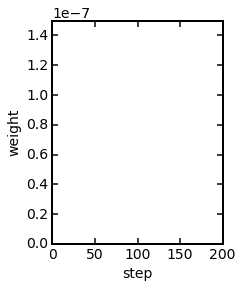

In [433]:
plt.rcParams.update({'font.size': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 1.5, 
                     'ytick.major.size': 6, 'ytick.major.width': 1.5, 
                     'xtick.minor.size': 3, 'xtick.minor.width': 1.,                   
                     'ytick.minor.size': 3, 'ytick.minor.width': 1.})  


with PdfPages('./fig/plots.pdf') as pdf:  
        
    for ii in range (0, N_par): 
       
        if((ii==0) | (ii==7) | (ii==14)):
            fig = plt.figure(figsize=(25,4))
            grid = gridspec.GridSpec(1, 7)            
            i_grid=0
              
        subplot=plt.subplot(grid[i_grid])
        i_grid+=1
      
        ylim=[10**min(df.iloc[:,ii+2]),10**max(df.iloc[:,ii+2])]
        ylim=[max(ylim[0]-(ylim[1]-ylim[0])/2.,ylim[0]/2.),ylim[1]+(ylim[1]-ylim[0])/2.]      
        Max_Nsteps=200
        xlim=[0, Max_Nsteps]         
        subplot.set_ylim(ylim), subplot.set_xlim(xlim)
           
        
        #format axis
        majorFormatter = FormatStrFormatter('%d')
        #subplot.xaxis.set_major_locator(MultipleLocator(1))    
        #subplot.xaxis.set_minor_locator(MultipleLocator(0.25)) 
                          
        subplot.set_xlabel('step', fontsize=14) 
        subplot.set_ylabel(Par_Names[ii], fontsize=14)    
        #plt.tick_params(axis='y', which='both', left='on', labelleft='off')
               
        x_axis=np.arange(0,Max_Nsteps,1.0)   
        
        for jj in range(0,N_chains):
            char_jj="%d" % jj  
            aux_df=pd.read_csv(chains_dir+chains_file+'_'+char_jj+'.txt',sep=' ',header=None)        
            subplot.plot(x_axis[0:len(aux_df.iloc[:,ii+2])],10**aux_df.iloc[:,ii+2], 
                         color='blue', linewidth=2, linestyle='-') 
         
         
        #plot 2-sigma regions         
        subplot.fill_between(x_axis,np.zeros(len(x_axis))+10**lower[ii],
                             np.zeros(len(x_axis))+10**upper[ii],
                             facecolor='skyblue', interpolate=True, alpha=0.4, edgecolor='skyblue')  
         
     

        if((ii==6) | (ii==13) | (ii==N_par-1)):    
            plt.tight_layout() 
            grid.update(wspace=0.2, hspace=0.0)
            pdf.savefig()
            plt.close()

print("plots done")

# 2D plots

In [26]:
from scipy.interpolate import griddata

plt.rcParams.update({'font.size': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 1.5, 
                     'ytick.major.size': 6, 'ytick.major.width': 1.5, 
                     'xtick.minor.size': 3, 'xtick.minor.width': 1.,                   
                     'ytick.minor.size': 3, 'ytick.minor.width': 1.})  


with PdfPages('./fig/plots.pdf') as pdf:  
    
    for ii in range (0, N_par-13): 
        print(ii)
        fig = plt.figure(figsize=(35,4))
        grid = gridspec.GridSpec(1, N_par-1)
        #grid.update(wspace=0.0, hspace=0.0)
        i_grid=0
        
        loop_count=0       
        for jj in range (0, N_par):
            
            
            if(jj==ii):
                continue
          
            subplot=plt.subplot(grid[i_grid])
            i_grid+=1
      
            plot_range=0.6
            median=(min(df.iloc[:,jj+2])+max(df.iloc[:,jj+2]))/2.
            xlim=[median-plot_range/2.,median+plot_range/2.]             
            median=(min(df.iloc[:,ii+2])+max(df.iloc[:,ii+2]))/2.
            ylim=[median-plot_range/2.,median+plot_range/2.]
            subplot.set_ylim(ylim), subplot.set_xlim(xlim)
           
       
            subplot.set_xlabel(Par_Names[jj], fontsize=14)
            if(loop_count==0):
                subplot.set_ylabel(Par_Names[ii], fontsize=14)    
            if(loop_count>0):                 
                plt.tick_params(axis='y', which='both', left='on', labelleft='off')
                
            subplot.xaxis.set_major_locator(MultipleLocator(0.25))    
            subplot.xaxis.set_minor_locator(MultipleLocator(0.1))     
            
            x_axis=df.iloc[:,jj+2]
            y_axis=df.iloc[:,ii+2]
            z_axis=df.iloc[:,1]
                
         
            xi,yi = np.mgrid[xlim[0]:xlim[1]:10j, ylim[0]:ylim[1]:10j]          
            zi = griddata((x_axis, y_axis), z_axis, (xi, yi), method='cubic', fill_value=300.)
            #contour the gridded data, plotting dots at the nonuniform data points.
            #nearest linear cubic
         
            zi=np.log10(zi/np.amax(zi))  
           
            zi = zoom(zi, 1)  
            #print(zi)
                
            mylevels = np.log10(np.logspace(-1.0, -0.0001, num=20))        
            cont=plt.contourf(zi, origin='lower', cmap='Greys', 
                              levels=mylevels, extent=[xlim[0],xlim[1],ylim[0], ylim[1]])  
            #cont=plt.contourf(zi, origin='lower', cmap='Greys', extent=[xlim[0],xlim[1],ylim[0], ylim[1]])  
            
            
            Nbins=20
            Hist, xedges, yedges = np.histogram2d(x_axis, y_axis, bins=Nbins,
                                               range=[[xlim[0]-0.5, xlim[1]+0.5], [ylim[0]-0.5, ylim[1]+0.5]])            
            extent = [xedges[0], xedges[-1],yedges[0], yedges[-1]]       
            plt.subplots_adjust(bottom=0.15, left=0.15)     
            mylevels = np.log10(np.logspace(-2.0, 0.0, num=3))  
            mylevels = np.log10([1-0.955,1.-0.683,1])
            Hist = zoom(Hist, 30)        
            Hist=np.log10(Hist/np.amax(Hist))       
            cont=plt.contour(Hist.transpose()[::], origin='lower', colors='black', 
                             levels=mylevels, extent=extent, linestyles='-')  

            loop_count+=1
            
        plt.tight_layout()  
        grid.update(wspace=0.05, hspace=0.0)
        pdf.savefig()
        plt.close()

print("plots done")

0
1
2
3
plots done
